In [29]:
import os
os.environ["MKL_THREADING_LAYER"] = "GNU"  

import matplotlib
#matplotlib.use('Agg')  # No GUI calls

import matplotlib.pyplot as plt

In [30]:
import torch
from torch import nn
import math
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np

In [31]:
batch_size=32

In [32]:
import random
random.seed(42)

In [33]:
def import_ff_data(filename):
    expected_columns=155
    data = []
    with open(filename, 'r') as file:
        for line in file:
            row = line.strip().split(',')
            if len(row) < expected_columns:
                row += [np.nan] * (expected_columns - len(row))
            data.append(row)
    df = pd.DataFrame(data)
    def fill_last_valid(row):
        for i in range(1, len(row)):
            if pd.isna(row[i]):
                row[i] = row[i - 1]  
        return row
    df_filled = df.apply(fill_last_valid, axis=1)
    return df_filled

In [34]:
ff_burned = import_ff_data("C:/Users/met48/Desktop/TS-Clustering/SimData/forest_fire_outputs_burned.csv")

In [35]:
data_output = ff_burned
data_output_helper = data_output
new_row = [500] * data_output_helper.shape[1]
data_output_helper.loc[len(data_output_helper)] = new_row
scaler = MinMaxScaler()
scaler.fit(data_output_helper)
data_output_scaled = scaler.transform(data_output)
data_output = pd.DataFrame(data_output_scaled)

# --- Load the conditioning input parameters ---
data_input = pd.read_csv("C:/Users/met48/Desktop/TS-Clustering/SimData/bank_reserves_inputs.csv", sep=" ", header=None)

# --- Combine input + output ---
data = pd.concat([data_input, data_output], axis=1)

# --- Sample to 1280 examples if needed ---
data = data.sample(n=20000, random_state=1)

# --- Split into training and validation sets ---
train_data_pd, valid_data = train_test_split(data, test_size=0.2, random_state=42)

# --- Extract tensors for training ---
train_inputs = torch.tensor(train_data_pd.iloc[:, :1].values, dtype=torch.float32)


train_outputs = torch.tensor(train_data_pd.iloc[:, 1:].values, dtype=torch.float32)

valid_inputs = torch.tensor(valid_data.iloc[:, :1].values, dtype=torch.float32)
valid_outputs = torch.tensor(valid_data.iloc[:, 1:].values, dtype=torch.float32)

In [36]:
data

,0,0,1,2,3,4,5,6,7,8,...,145,146,147,148,149,150,151,152,153,154
3915,78.432312,0.0,0.442,0.603430,0.578947,0.576248,0.568065,0.554815,0.544129,0.549112,...,0.8041,0.8041,0.8041,0.8041,0.8041,0.8041,0.8041,0.8041,0.8041,0.8041
28069,45.022241,0.0,0.070,0.048232,0.036585,0.026802,0.021339,0.017565,0.015100,0.013037,...,0.0058,0.0058,0.0058,0.0058,0.0058,0.0058,0.0058,0.0058,0.0058,0.0058
80496,23.626896,0.0,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
51846,32.434221,0.0,0.240,0.301179,0.272786,0.261091,0.265269,0.272865,0.276751,0.273994,...,0.5767,0.5767,0.5767,0.5767,0.5767,0.5767,0.5767,0.5767,0.5767,0.5767
55195,11.637353,0.0,0.206,0.254019,0.215661,0.200555,0.202355,0.198062,0.202291,0.211283,...,0.5160,0.5160,0.5160,0.5160,0.5160,0.5160,0.5160,0.5160,0.5160,0.5160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28247,47.415942,0.0,0.060,0.049303,0.032092,0.023567,0.018764,0.015445,0.013278,0.011463,...,0.0051,0.0051,0.0051,0.0051,0.0051,0.0051,0.0051,0.0051,0.0051,0.0051
25808,61.464472,0.0,0.374,0.394427,0.369705,0.360444,0.380427,0.386432,0.385316,0.377163,...,0.6649,0.6649,0.6649,0.6649,0.6649,0.6649,0.6649,0.6649,0.6649,0.6649
3529,75.743780,0.0,0.642,0.847803,0.808087,0.841035,0.847314,0.826469,0.839104,0.836368,...,0.9728,0.9728,0.9728,0.9728,0.9728,0.9728,0.9728,0.9728,0.9728,0.9728
35199,58.235536,0.0,0.254,0.258307,0.227856,0.220887,0.216336,0.219261,0.217391,0.222971,...,0.5343,0.5343,0.5343,0.5343,0.5343,0.5343,0.5343,0.5343,0.5343,0.5343


In [37]:
train_inputs.shape[0]

16000

In [38]:
torch.manual_seed(1)

In [39]:
train_data_length = train_inputs.shape[0]
train_data = torch.from_numpy(train_data_pd.values).float().to('cpu')
train_labels = torch.zeros(train_data_length)
train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)
]
train_data.shape

torch.Size([16000, 156])

In [42]:
from torch.utils.data import Dataset

class ConditionalTimeSeriesDataset(Dataset):
    def __init__(self, time_series_data, condition_data):
        """
        time_series_data: Tensor of shape (N, 252)
        condition_data: Tensor of shape (N, 3)
        """
        self.time_series_data = time_series_data
        self.condition_data = condition_data

    def __len__(self):
        return len(self.time_series_data)

    def __getitem__(self, idx):
        return self.time_series_data[idx], self.condition_data[idx]

In [43]:
from torch.utils.data import DataLoader

train_dataset = ConditionalTimeSeriesDataset(train_outputs, train_inputs)
valid_dataset = ConditionalTimeSeriesDataset(valid_outputs, valid_inputs)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)
print(f"Steps per epoch: {len(train_loader)}")

Steps per epoch: 500


In [44]:
input_dim_var=155
class ConditionalDiscriminator(nn.Module):
    def __init__(self, input_dim=input_dim_var, condition_dim=1):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim + condition_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x, conditions):
        # Concatenate time series and condition
        x = torch.cat([x, conditions], dim=1)
        return self.model(x)

In [45]:
discriminator = ConditionalDiscriminator()

In [46]:
from torchsummary import summary
print(discriminator)

ConditionalDiscriminator(
  (model): Sequential(
    (0): Linear(in_features=156, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=128, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


In [47]:
class ConditionalGenerator(nn.Module):
    def __init__(self, latent_dim=100, condition_dim=1, output_len=155, hidden_dim=64):
        super().__init__()
        self.input_proj = nn.Linear(latent_dim + condition_dim, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.output_proj = nn.Linear(hidden_dim, 1)
        self.output_len = output_len

    def forward(self, z, conditions):
        batch_size = z.size(0)
        x = torch.cat([z, conditions], dim=1)
        x = self.input_proj(x)  # (B, H)

        # Repeat across time steps
        x = x.unsqueeze(1).repeat(1, self.output_len, 1)  # (B, T, H)
        lstm_out, _ = self.lstm(x)
        out = self.output_proj(lstm_out).squeeze(-1)  # (B, T)
        return out

generator = ConditionalGenerator()

In [48]:
lr = 0.001
num_epochs = 120
loss_function = nn.BCELoss()

In [49]:
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [50]:
losses_discriminator = []
losses_generator = []
steps = []

for epoch in range(num_epochs):
    for n, (real_samples, condition_vectors) in enumerate(train_loader):
        # real_samples: (batch_size, 252)
        # condition_vectors: (batch_size, 3)

        real_samples_labels = torch.ones((batch_size, 1))
        generated_samples_labels = torch.zeros((batch_size, 1))

        # Sample latent space
        latent_dim = 100
        latent_space_samples = torch.randn((batch_size, latent_dim))  # Latent space dimension

        # Ensure condition_vectors has the same batch size as latent_space_samples
        condition_vectors = condition_vectors.expand(batch_size, -1)  # Repeat condition vectors to match batch size

        # === Generator step ===
        # Pass latent_space_samples and condition_vectors separately to the generator
        generated_samples = generator(latent_space_samples, condition_vectors)

        # === Prepare discriminator input ===
        all_samples = torch.cat((real_samples, generated_samples.detach()), dim=0)
        all_conditions = torch.cat((condition_vectors, condition_vectors), dim=0)  # Duplicate for both real and generated
        all_labels = torch.cat((real_samples_labels, generated_samples_labels), dim=0)

        # === Train discriminator ===
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples, all_conditions)
        loss_discriminator = loss_function(output_discriminator, all_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # === Train generator ===
        generator.zero_grad()
        # Generate again to avoid using detached samples
        generated_samples = generator(latent_space_samples, condition_vectors)
        output_discriminator_generated = discriminator(generated_samples, condition_vectors)
        loss_generator = loss_function(output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()

        # === Logging (every 100 iterations per epoch) ===
        if n % 100 == 0 and epoch % 25 == 0:  # Adjust this number to control how often you log
            losses_discriminator.append(loss_discriminator.item())
            losses_generator.append(loss_generator.item())
            steps.append(epoch * len(train_loader) + n)
            print(f"Epoch: {epoch} Step: {n} Loss D.: {loss_discriminator.item()}")
            print(f"Epoch: {epoch} Step: {n} Loss G.: {loss_generator.item()}")


Epoch: 0 Step: 0 Loss D.: 0.705901026725769
Epoch: 0 Step: 0 Loss G.: 1.1682801246643066
Epoch: 0 Step: 100 Loss D.: 0.7020937204360962
Epoch: 0 Step: 100 Loss G.: 0.813367486000061
Epoch: 0 Step: 200 Loss D.: 0.5589220523834229
Epoch: 0 Step: 200 Loss G.: 1.0678577423095703
Epoch: 0 Step: 300 Loss D.: 0.7260086536407471
Epoch: 0 Step: 300 Loss G.: 0.9888765811920166
Epoch: 0 Step: 400 Loss D.: 0.6171740293502808
Epoch: 0 Step: 400 Loss G.: 0.6677480340003967
Epoch: 25 Step: 0 Loss D.: 0.5095933675765991
Epoch: 25 Step: 0 Loss G.: 1.0507678985595703
Epoch: 25 Step: 100 Loss D.: 0.5562323331832886
Epoch: 25 Step: 100 Loss G.: 1.0527749061584473
Epoch: 25 Step: 200 Loss D.: 0.7317110896110535
Epoch: 25 Step: 200 Loss G.: 1.0037569999694824
Epoch: 25 Step: 300 Loss D.: 0.6280679702758789
Epoch: 25 Step: 300 Loss G.: 0.8560050129890442
Epoch: 25 Step: 400 Loss D.: 0.6604219079017639
Epoch: 25 Step: 400 Loss G.: 0.8238931894302368
Epoch: 50 Step: 0 Loss D.: 0.7397559285163879
Epoch: 50 Step

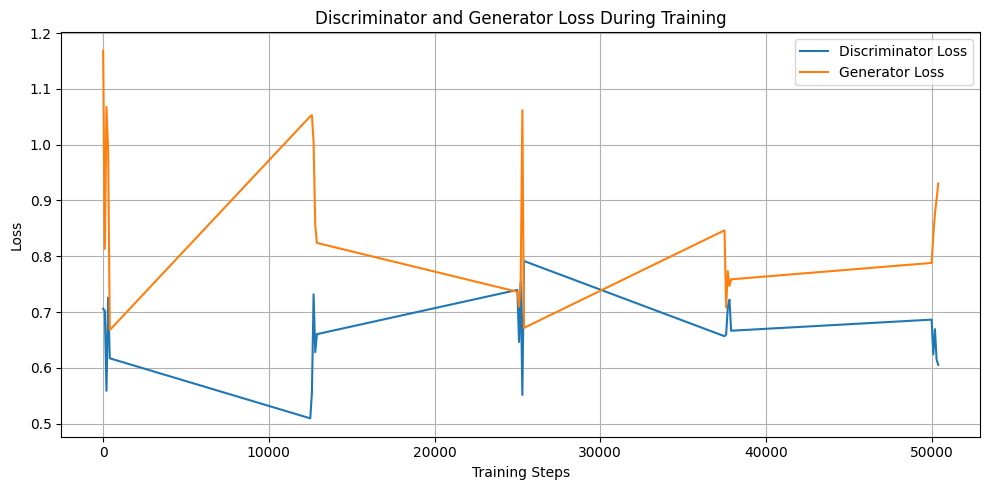

In [51]:
plt.figure(figsize=(10, 5))
plt.plot(steps, losses_discriminator, label='Discriminator Loss')
plt.plot(steps, losses_generator, label='Generator Loss')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Discriminator and Generator Loss During Training')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [52]:
torch.save(generator.state_dict(), "generator_gan_ff_lstm_es.pth")
torch.save(discriminator.state_dict(), "discriminator_gan_ff_lstm_es.pth") 

In [53]:
import random

# Pick N random examples from your validation set
n_samples = 4000
indices = random.sample(range(len(valid_dataset)), n_samples)

real_samples = []
real_conditions = []

for idx in indices:
    real_ts, condition = valid_dataset[idx]
    real_samples.append(real_ts)
    real_conditions.append(condition)

real_samples = torch.stack(real_samples)           # (n_samples, 252)
real_conditions = torch.stack(real_conditions)     # (n_samples, 3)

In [54]:
generator.eval()
with torch.no_grad():
    latent_dim = 100  # or whatever your latent size is
    z = torch.randn(n_samples, latent_dim)
    generated_samples = generator(z, real_conditions)  # (n_samples, 252)

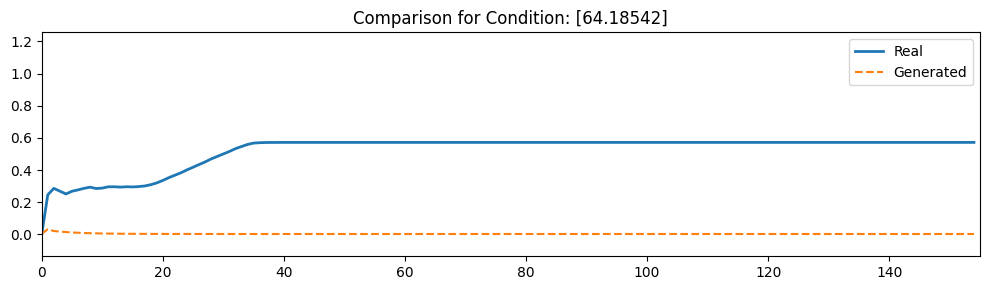

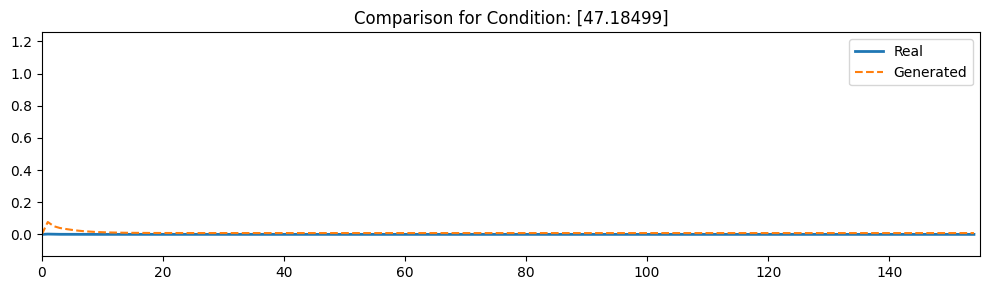

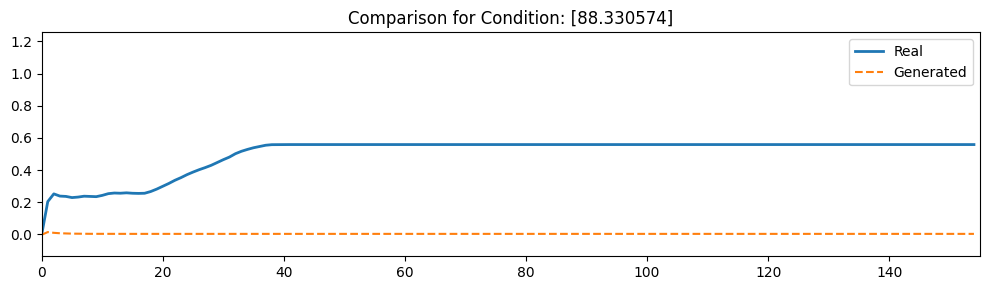

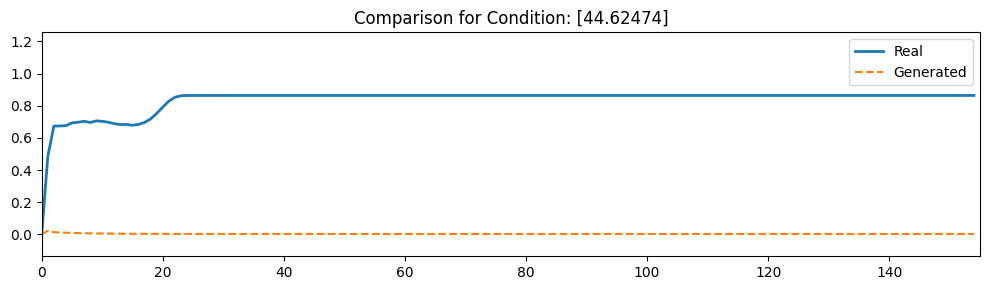

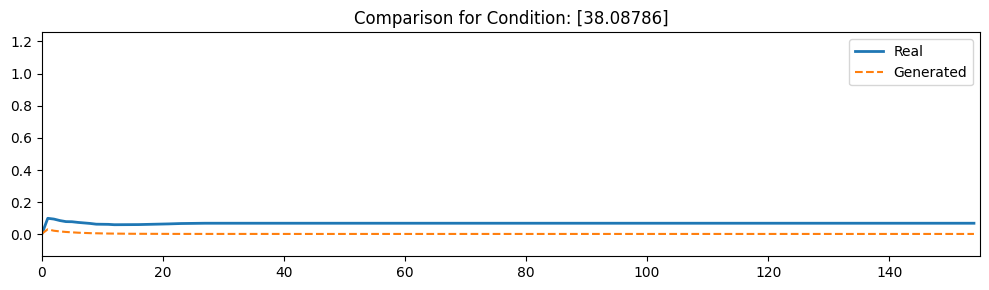

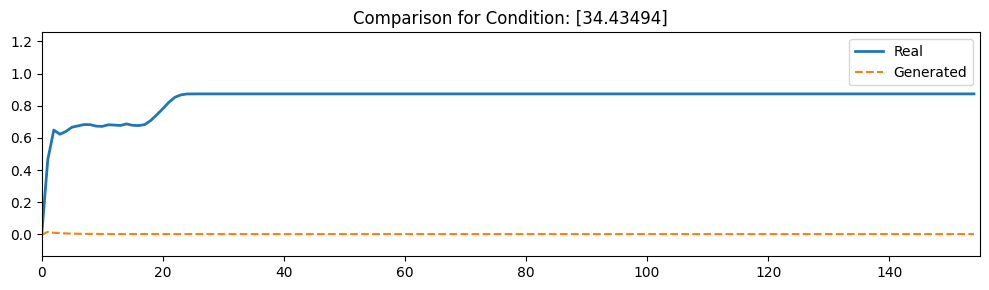

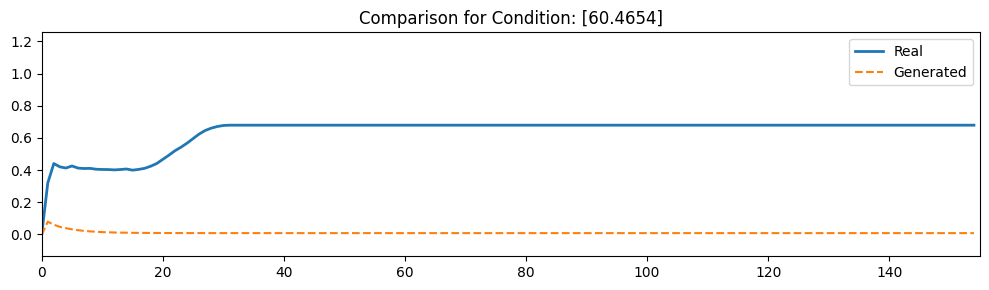

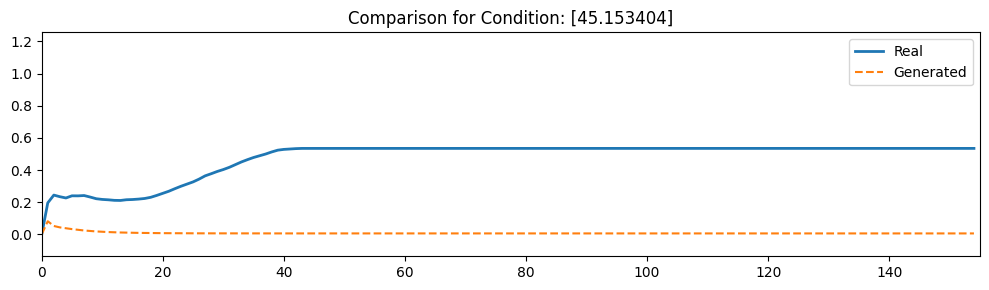

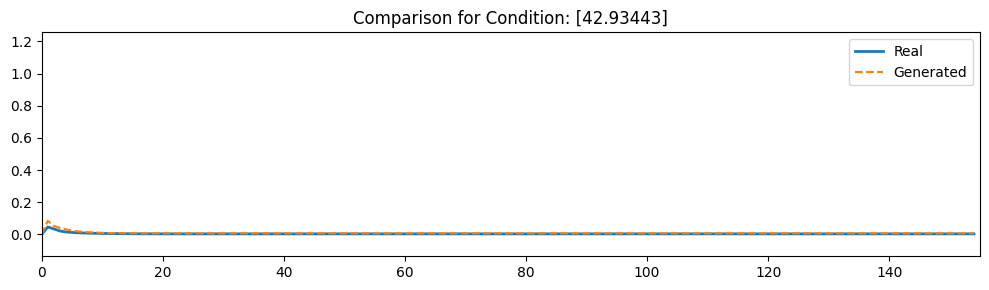

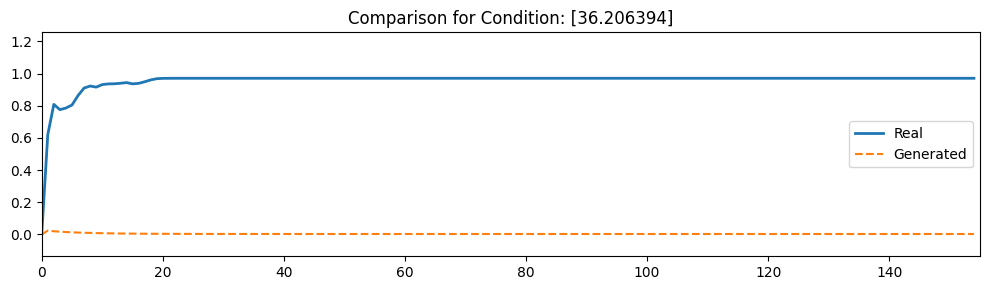

In [55]:
import matplotlib.pyplot as plt

# Calculate the global min and max for both real and generated samples
min_val = min(real_samples.min(), generated_samples.min())
max_val = max(real_samples.max(), generated_samples.max())

# Assuming real_samples, generated_samples, and real_conditions are already in the correct shape

for i in range(10):
    plt.figure(figsize=(10, 3))
    plt.plot(real_samples[i].cpu().numpy(), label="Real", linewidth=2)
    plt.plot(generated_samples[i].cpu().numpy(), label="Generated", linestyle="--")
    
    # Set the axis limits based on global min and max
    plt.xlim(0, len(real_samples[i]))  # Standardize x-axis (if you know your x range)
    plt.ylim(min_val, max_val)  # Standardize y-axis

    plt.title(f"Comparison for Condition: {real_conditions[i].cpu().numpy()}")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [56]:
def evaluate_model_gan(real_samples, generated_samples):

    # convert list to numpy arrays
    predicted_values = generated_samples.cpu().numpy()  # [N, 255, 1]
    true_values = real_samples.cpu().numpy()            # [N, 255, 1]

    # flatten for metrics
    y_pred_flat = predicted_values.flatten()
    y_true_flat = true_values.flatten()
    
    # compute evaluation metrics
    mse = mean_squared_error(y_true_flat, y_pred_flat)
    mae = mean_absolute_error(y_true_flat, y_pred_flat)
    r2 = r2_score(y_true_flat, y_pred_flat)

    print(f"Validation MSE: {mse:.6f}")
    print(f"Validation MAE: {mae:.6f}")
    print(f"Validation R² Score: {r2:.6f}")

    return mse, mae, r2

In [57]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
evaluate_model_gan(real_samples, generated_samples)

Validation MSE: 0.277971
Validation MAE: 0.395577
Validation R² Score: -1.147320


(0.277970552444458, 0.3955768942832947, -1.147320032119751)